In [5]:
import numpy as np
import torch
import os
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score
from torch import nn
from torch.nn import functional as F
from tqdm import trange, tqdm


def ece(probs, labels, n_bins=30):
    '''
    probs has shape [n_examples, n_classes], labels has shape [n_class] -> np.float
    Computes the Expected Calibration Error (ECE). Many options are possible,
    in this implementation,  we provide a simple version.

    Using a uniform binning scheme on the full range of probabilities, zero
    to one, we bin the probabilities of the predicted label only (ignoring
    all other probabilities). For the ith bin, we compute the avg predicted
    probability, p_i, and the bin's total accuracy, a_i. We then compute the
    ith calibration error of the bin, |p_i - a_i|. The final returned value
    is the weighted average of calibration errors of each bin.
    '''
    n_examples, n_classes = probs.shape

    # assume that the prediction is the class with the highest prob.
    preds = np.argmax(probs, axis=1)

    onehot_labels = np.eye(n_classes)[labels]

    predicted_class_probs = probs[range(n_examples), preds]

    # Use uniform bins on the range of probabilities, i.e. closed interval [0.,1.]
    bin_upper_edges = np.histogram_bin_edges([], bins=n_bins, range=(0., 1.))
    bin_upper_edges = bin_upper_edges[1:] # bin_upper_edges[0] = 0.

    probs_as_bin_num = np.digitize(predicted_class_probs, bin_upper_edges)
    sums_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins, weights=predicted_class_probs)
    sums_per_bin = sums_per_bin.astype(np.float32)

    total_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins) \
        + np.finfo(sums_per_bin.dtype).eps # division by zero
    avg_prob_per_bin = sums_per_bin / total_per_bin

    accuracies = onehot_labels[range(n_examples), preds] # accuracies[i] is 0 or 1
    accuracies_per_bin = np.bincount(probs_as_bin_num, weights=accuracies, minlength=n_bins) \
        / total_per_bin

    prob_of_being_in_a_bin = total_per_bin / float(n_examples)

    ece_ret = np.abs(accuracies_per_bin - avg_prob_per_bin) * prob_of_being_in_a_bin
    ece_ret = np.sum(ece_ret)
    return ece_ret


def load_rotated_mnist():
    '''
    The difference between MNIST and Rotated MNIST is that Rotated MNIST has
    rotated *test* images.
    '''

    mnist_path = "/data/rotated_mnist.npz"
    if not os.path.isfile(mnist_path):
        mnist_path = os.path.join(os.getcwd(), "data/rotated_mnist.npz")

    data = np.load(mnist_path)

    x_train = torch.from_numpy(data["x_train"]).reshape([-1, 784])
    y_train = torch.from_numpy(data["y_train"])

    dataset_train = torch.utils.data.TensorDataset(x_train, y_train)

    return dataset_train


class Densenet(torch.nn.Module):
    '''
    Simple module implementing a feedforward neural network with
    num_layers layers of size width and input of size input_size.
    '''
    def __init__(self, input_size, num_layers, width):
        super().__init__()
        input_layer = torch.nn.Sequential(nn.Linear(input_size, width),
                                           nn.ReLU())
        hidden_layers = [nn.Sequential(nn.Linear(width, width),
                                    nn.ReLU()) for _ in range(num_layers)]
        output_layer = torch.nn.Linear(width, 10)
        layers = [input_layer, *hidden_layers, output_layer]
        self.net = torch.nn.Sequential(*layers)


    def forward(self, x):
        out = self.net(x)
        return out


    def predict_class_probs(self, x):
        probs = F.softmax(self.forward(x), dim=1)
        return probs

class BayesianLayer(torch.nn.Module):
    '''
    Module implementing a single Bayesian feedforward layer.
    The module performs Bayes-by-backprop, that is, mean-field
    variational inference. It keeps prior and posterior weights
    (and biases) and uses the reparameterization trick for sampling.
    '''
    def __init__(self, input_dim, output_dim, bias=True):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = bias

        self.prior_mu = 0
        self.prior_sigma = 1
        self.weight_mu = nn.Parameter(torch.FloatTensor(input_dim, output_dim).normal_(mean=0, std=0.001))
        self.weight_logsigma = nn.Parameter(torch.FloatTensor(input_dim, output_dim).normal_(mean=-2, std=0.001))

        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.zeros(output_dim))
            self.bias_logsigma = nn.Parameter(torch.zeros(output_dim))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_logsigma', None)


    def forward(self, inputs):

        sigma = torch.log(1 + torch.exp(self.weight_logsigma)) 
        eps = torch.randn_like(sigma)
        self.w = self.weight_mu + (eps * sigma)

        if self.use_bias:
            sigma = torch.log(1 + torch.exp(self.bias_logsigma))
            eps = torch.randn_like(sigma)
            self.b = self.bias_mu + (eps * sigma)
        else:
            bias = None

        outputs = inputs @ self.w + self.b

        return outputs


    def kl_divergence(self):
        '''
        Computes the KL divergence between the priors and posteriors for this layer.
        '''
        kl_loss = self._kl_divergence(self.weight_mu, self.weight_logsigma)
        if self.use_bias:
            kl_loss += self._kl_divergence(self.bias_mu, self.bias_logsigma)
        return kl_loss


    def _kl_divergence(self, mu, logsigma):
        '''
        Computes the KL divergence between one Gaussian posterior
        and the Gaussian prior.
        '''
        log_prior = torch.distributions.Normal(self.prior_mu, self.prior_sigma).log_prob(self.w) 
        log_theta_q = torch.distributions.Normal(self.weight_mu, torch.log(1 + torch.exp( self.weight_logsigma))).log_prob(self.w) 
        kl = (log_theta_q - log_prior).sum() #TODO divided by something?

        return kl


class BayesNet(torch.nn.Module):
    '''
    Module implementing a Bayesian feedforward neural network using
    BayesianLayer objects.
    '''
    def __init__(self, input_size, num_layers, width):
        super().__init__()
        input_layer = torch.nn.Sequential(BayesianLayer(input_size, width),
                                           nn.ReLU())
        hidden_layers = [nn.Sequential(BayesianLayer(width, width),
                                    nn.ReLU()) for _ in range(num_layers)]
        output_layer = BayesianLayer(width, 10)
        layers = [input_layer, *hidden_layers, output_layer]
        self.net = torch.nn.Sequential(*layers)
        self.num_layers = num_layers

    def forward(self, x):
        return self.net(x)


    def predict_class_probs(self, x, num_forward_passes=10):
        assert x.shape[1] == 28**2
        batch_size = x.shape[0]

        # TODO: make n random forward passes
        # compute the categorical softmax probabilities
        # marginalize the probabilities over the n forward passes
        probs = F.softmax(self.forward(x), dim=1)
        for i in range(1,num_forward_passes):
            probs += F.softmax(self.forward(x), dim=1)
        probs /= num_forward_passes

        assert probs.shape == (batch_size, 10)
        
        return probs


    def kl_loss(self):
        '''
        Computes the KL divergence loss for all layers.
        '''
        # TODO: enter your code here
        kl_loss = self.net[0][0].kl_divergence()
        for i in range(1,1+self.num_layers):
#             print(self.net)
#             print(self.net[0])
#             #print(model.net[0].kl_divergence())
#             print(self.net[0][0])
#             print((self.net[0][0]).input_dim)
#             print((self.net[0][0]).kl_divergence())
            kl_loss = kl_loss + (self.net[i][0]).kl_divergence()
        kl_loss = kl_loss + (self.net[-1]).kl_divergence()
        
        return kl_loss
        

#         kl_sum = 0.0
#         for layer in self.layers:
#             kl_sum += layer.kl_divergence()
#         return kl_sum #TODO does it work or should we have two outputs to the forward Bayesian Layer??


def train_network(model, optimizer, train_loader, num_epochs=100, pbar_update_interval=100):
    '''
    Updates the model parameters (in place) using the given optimizer object.
    Returns `None`.

    The progress bar computes the accuracy every `pbar_update_interval`
    iterations.
    '''
    criterion = torch.nn.CrossEntropyLoss() # always used in this assignment

    pbar = trange(num_epochs)
    for i in pbar:
        for k, (batch_x, batch_y) in enumerate(train_loader):
            model.zero_grad()
            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y)
            if type(model) == BayesNet:
                # BayesNet implies additional KL-loss.
                kl = model.kl_loss() #accumulated loss
                loss = loss + kl # reconstruction_error + Kl divergence 
            loss.backward()
            optimizer.step()

            if k % pbar_update_interval == 0:
                acc = (model(batch_x).argmax(axis=1) == batch_y).sum().float()/(len(batch_y))
                pbar.set_postfix(loss=loss.item(), acc=acc.item())


def evaluate_model(model, model_type, test_loader, batch_size, extended_eval, private_test):
    '''
    Evaluates the trained model based on accuracy and ECE.
    If extended_eval is True, also computes predictive confidences
    on the FashionMNIST data set (out-of-distribution/OOD) and saves the
    most and least confidently classified images for both data sets
    as well as the classification performance for OOD detection based
    on the predictive confidences.
    '''
    accs_test = []
    probs = torch.tensor([])
    labels = torch.tensor([]).long()
    for batch_x, batch_y in test_loader:
        pred = model.predict_class_probs(batch_x)
        probs = torch.cat((probs, pred))
        labels = torch.cat((labels, batch_y))
        acc = (pred.argmax(axis=1) == batch_y).sum().float().item()/(len(batch_y))
        accs_test.append(acc)

    if not private_test:
        acc_mean = np.mean(accs_test)
        ece_mean = ece(probs.detach().numpy(), labels.numpy())
        print(f"Model type: {model_type}\nAccuracy = {acc_mean:.3f}\nECE = {ece_mean:.3f}")
    else:
        print("Using private test set.")

    final_probs = probs.detach().numpy()

    if extended_eval:
        confidences = []
        for batch_x, batch_y in test_loader:
            pred = model.predict_class_probs(batch_x)
            confs, _ = pred.max(dim=1)
            confidences.extend(confs.detach().numpy())

        confidences = np.array(confidences)

        fig, axs = plt.subplots(ncols=10, figsize=(20,2))
        for ax, idx in zip(axs, confidences.argsort()[-10:]):
            ax.imshow(test_loader.dataset.tensors[0][idx].numpy().reshape((28,28)), cmap="gray")
            ax.axis("off")
        fig.suptitle("Most confident predictions", size=20);
        fig.savefig(f"mnist_most_confident_{model_type}.pdf")

        fig, axs = plt.subplots(ncols=10, figsize=(20,2))
        for ax, idx in zip(axs, confidences.argsort()[:10]):
            ax.imshow(test_loader.dataset.tensors[0][idx].numpy().reshape((28,28)), cmap="gray")
            ax.axis("off")
        fig.suptitle("Least confident predictions", size=20);
        fig.savefig(f"mnist_least_confident_{model_type}.pdf")

        fmnist_path = "/data/fashion/fmnist.npz"
        if not os.path.isfile(fmnist_path):
            fmnist_path = os.path.join(os.getcwd(), "data/fashion/fmnist.npz")
        data_fmnist = np.load(fmnist_path)["x_test"]
        dataset_fmnist = torch.utils.data.TensorDataset(torch.tensor(data_fmnist))
        dataloader_fmnist = torch.utils.data.DataLoader(dataset_fmnist, batch_size=batch_size)

        confidences_fmnist = []
        for batch_x in dataloader_fmnist:
            pred = model.predict_class_probs(batch_x[0])
            confs, _ = pred.max(dim=1)
            confidences_fmnist.extend(confs.detach().numpy())

        confidences_fmnist = np.array(confidences_fmnist)

        fig, axs = plt.subplots(ncols=10, figsize=(20,2))
        for ax, idx in zip(axs, confidences_fmnist.argsort()[-10:]):
            ax.imshow(dataloader_fmnist.dataset.tensors[0][idx].numpy().reshape((28,28)), cmap="gray")
            ax.axis("off")
        fig.suptitle("Most confident predictions", size=20);
        fig.savefig(f"fashionmnist_most_confident_{model_type}.pdf")

        fig, axs = plt.subplots(ncols=10, figsize=(20,2))
        for ax, idx in zip(axs, confidences_fmnist.argsort()[:10]):
            ax.imshow(dataloader_fmnist.dataset.tensors[0][idx].numpy().reshape((28,28)), cmap="gray")
            ax.axis("off")
        fig.suptitle("Least confident predictions", size=20);
        fig.savefig(f"fashionmnist_least_confident_{model_type}.pdf")

        confidences_all = np.concatenate([confidences, confidences_fmnist])
        dataset_labels = np.concatenate([np.ones_like(confidences), np.zeros_like(confidences_fmnist)])

        print(f"AUROC for MNIST vs. FashionMNIST OOD detection based on {model_type} confidence: "
              f"{roc_auc_score(dataset_labels, confidences_all):.3f}")
        print(f"AUPRC for MNIST vs. FashionMNIST OOD detection based on {model_type} confidence: "
              f"{average_precision_score(dataset_labels, confidences_all):.3f}")

    return final_probs


def main(test_loader=None, private_test=False):
    num_epochs = 100 # You might want to adjust this
    batch_size = 128  # Try playing around with this
    print_interval = 100
    learning_rate = 5e-4  # Try playing around with this
    model_type = "bayesnet"  # Try changing this to "densenet" as a comparison
    extended_evaluation = True  # Set this to True for additional model evaluation

    dataset_train = load_rotated_mnist()
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                               shuffle=True, drop_last=True)

    if model_type == "bayesnet":
        model = BayesNet(input_size=784, num_layers=2, width=100)
    elif model_type == "densenet":
        model = Densenet(input_size=784, num_layers=2, width=100)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_network(model, optimizer, train_loader, num_epochs=num_epochs, pbar_update_interval=print_interval)

    if test_loader is None:
        print("evaluating on train data")
        test_loader = train_loader
    else:
        print("evaluating on test data")

    # Do not change this! The main() method should return the predictions for the test loader
    predictions = evaluate_model(model, model_type, test_loader, batch_size, extended_evaluation, private_test)
    return predictions





100%|██████████| 100/100 [50:05<00:00, 30.05s/it, acc=0.148, loss=504]    


evaluating on train data
Model type: bayesnet
Accuracy = 0.117
ECE = 0.130
AUROC for MNIST vs. FashionMNIST OOD detection based on bayesnet confidence: 0.467
AUPRC for MNIST vs. FashionMNIST OOD detection based on bayesnet confidence: 0.839


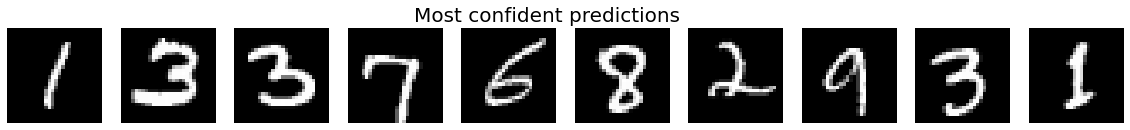

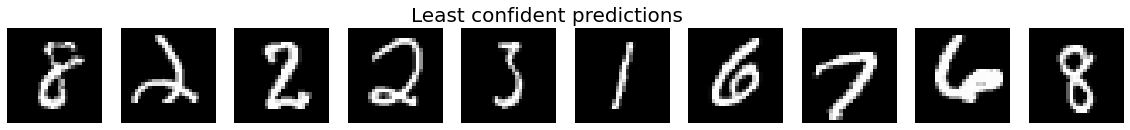

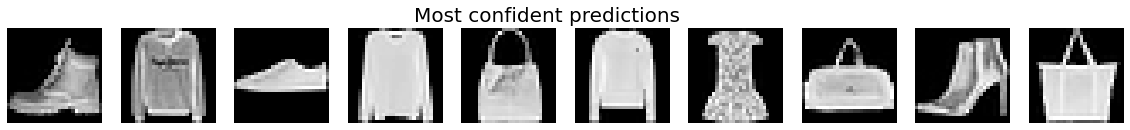

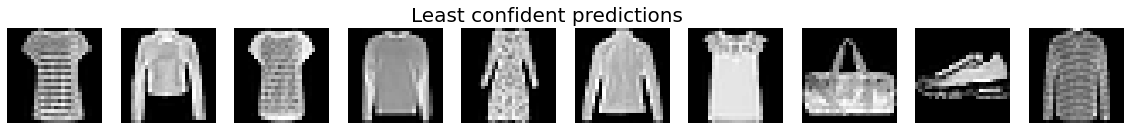

In [6]:
prediction = main()